In [1]:
import os, sys
import time, math
import argparse, random
from math import exp
import numpy as np

import torch
from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader
from torch.backends import cudnn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as tfs
from torchvision.transforms import ToPILImage
from torchvision.transforms import functional as FF
import torchvision.utils as vutils
from torchvision.utils import make_grid
from torchvision.models import vgg16

from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d balraj98/ffanet-pretrained-weights
! unzip /content/ffanet-pretrained-weights.zip
! kaggle datasets download -d balraj98/synthetic-objective-testing-set-sots-reside
! unzip /content/synthetic-objective-testing-set-sots-reside.zip

Saving kaggle.json to kaggle.json
 93% 35.0M/37.5M [00:01<00:00, 19.1MB/s]
100% 37.5M/37.5M [00:01<00:00, 23.2MB/s]


In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Num residual_groups
gps = 3
# Num residual_blocks
blocks = 19
# Directory of test imgs
img_dir = '/content/indoor/hazy'
# Pre-trained checkpoint dir
pretrained_model_dir = '/content/its_train_ffa_3_19.pk'
# Output dir to save predicted de-hazed images
output_dir = f'pred_FFA_its/'

if not os.path.exists(output_dir):
    os.mkdir(output_dir)

In [6]:
def tensorShow(tensors,titles=None):
    '''t:BCWH'''
    fig=plt.figure()
    for tensor, title, i in zip(tensors, titles, range(len(tensors))):
        img = make_grid(tensor)
        npimg = img.numpy()
        ax = fig.add_subplot(211+i)
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
        ax.set_title(title)
    plt.show()

In [7]:
def default_conv(in_channels, out_channels, kernel_size, bias=True):
    return nn.Conv2d(in_channels, out_channels, kernel_size, padding=(kernel_size//2), bias=bias)


class PALayer(nn.Module):
    def __init__(self, channel):
        super(PALayer, self).__init__()
        self.pa = nn.Sequential(
                nn.Conv2d(channel, channel // 8, 1, padding=0, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // 8, 1, 1, padding=0, bias=True),
                nn.Sigmoid()
        )
    def forward(self, x):
        y = self.pa(x)
        return x * y


class CALayer(nn.Module):
    def __init__(self, channel):
        super(CALayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.ca = nn.Sequential(
                nn.Conv2d(channel, channel // 8, 1, padding=0, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // 8, channel, 1, padding=0, bias=True),
                nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.ca(y)
        return x * y


class Block(nn.Module):
    def __init__(self, conv, dim, kernel_size,):
        super(Block, self).__init__()
        self.conv1 = conv(dim, dim, kernel_size, bias=True)
        self.act1 = nn.ReLU(inplace=True)
        self.conv2 = conv(dim, dim, kernel_size, bias=True)
        self.calayer = CALayer(dim)
        self.palayer = PALayer(dim)

    def forward(self, x):
        res = self.act1(self.conv1(x))
        res = res+x
        res = self.conv2(res)
        res = self.calayer(res)
        res = self.palayer(res)
        res += x
        return res


class Group(nn.Module):
    def __init__(self, conv, dim, kernel_size, blocks):
        super(Group, self).__init__()
        modules = [Block(conv, dim, kernel_size)  for _ in range(blocks)]
        modules.append(conv(dim, dim, kernel_size))
        self.gp = nn.Sequential(*modules)

    def forward(self, x):
        res = self.gp(x)
        res += x
        return res


class FFA(nn.Module):
    def __init__(self,gps,blocks,conv=default_conv):
        super(FFA, self).__init__()
        self.gps = gps
        self.dim = 64
        kernel_size = 3
        pre_process = [conv(3, self.dim, kernel_size)]
        assert self.gps==3
        self.g1 = Group(conv, self.dim, kernel_size,blocks=blocks)
        self.g2 = Group(conv, self.dim, kernel_size,blocks=blocks)
        self.g3 = Group(conv, self.dim, kernel_size,blocks=blocks)
        self.ca = nn.Sequential(*[
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(self.dim*self.gps,self.dim//16,1,padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(self.dim//16, self.dim*self.gps, 1, padding=0, bias=True),
            nn.Sigmoid()
            ])
        self.palayer = PALayer(self.dim)

        post_process = [
            conv(self.dim, self.dim, kernel_size),
            conv(self.dim, 3, kernel_size)]

        self.pre = nn.Sequential(*pre_process)
        self.post = nn.Sequential(*post_process)

    def forward(self, x1):
        x = self.pre(x1)
        res1 = self.g1(x)
        res2 = self.g2(res1)
        res3 = self.g3(res2)
        w = self.ca(torch.cat([res1,res2,res3],dim=1))
        w = w.view(-1,self.gps, self.dim)[:,:,:,None,None]
        out = w[:,0,::] * res1 + w[:,1,::] * res2+w[:,2,::] * res3
        out = self.palayer(out)
        x = self.post(out)
        return x + x1

In [15]:
import time

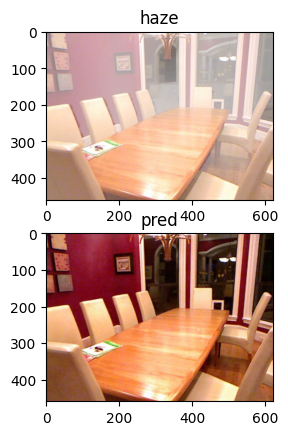

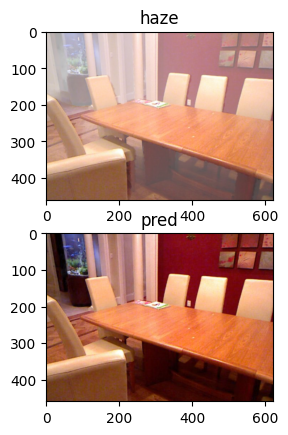

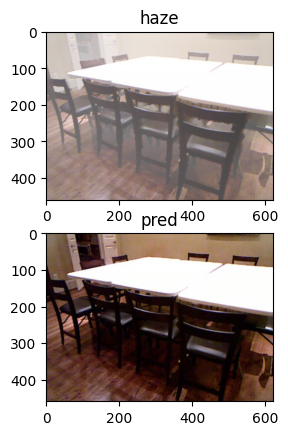

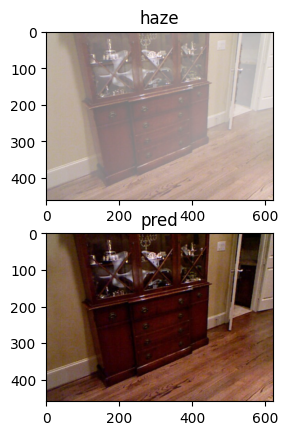

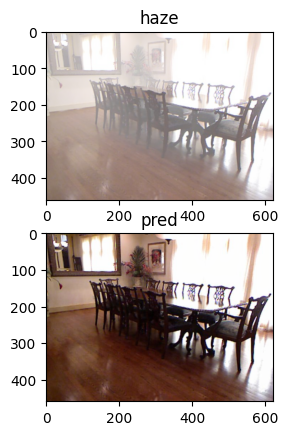

In [ ]:
ckp = torch.load(pretrained_model_dir, map_location=device)
net = FFA(gps=gps, blocks=blocks)
net = nn.DataParallel(net)
net.load_state_dict(ckp['model'])
net.eval()

img_paths = sorted(os.listdir(img_dir))
img_paths = [img_path for img_path in img_paths if '_10.' in img_path]

start = time.time()
for im in img_paths:
    haze = Image.open(img_dir+'/'+im)
    haze1 = tfs.Compose([
        tfs.ToTensor(),
        tfs.Normalize(mean=[0.64, 0.6, 0.58],std=[0.14,0.15, 0.152])
    ])(haze)[None,::]
    haze_no = tfs.ToTensor()(haze)[None,::]
    with torch.no_grad():
        pred = net(haze1)
    ts = torch.squeeze(pred.clamp(0,1).cpu())
    tensorShow([haze_no, pred.clamp(0,1).cpu()],['haze', 'pred'])

    haze_no = make_grid(haze_no, nrow=1, normalize=True)
    ts = make_grid(ts, nrow=1, normalize=True)
    image_grid = torch.cat((haze_no, ts), -1)
    # vutils.save_image(image_grid, output_dir+im.split('.')[0]+'_FFA.png')
end = time.time()

print(end-start)